In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [2]:
from google.colab import files 
files.upload() 

Saving plus.txt to plus (4).txt


{'plus.txt': b'468+797\t1265\r\n646+744\t1390\r\n949+470\t1419\r\n860+513\t1373\r\n542+772\t1314\r\n244+757\t1001\r\n117+357\t474\r\n379+304\t683\r\n290+621\t911\r\n668+564\t1232\r\n587+183\t770\r\n543+506\t1049\r\n196+549\t745\r\n736+813\t1549\r\n674+432\t1106\r\n133+24\t157\r\n977+692\t1669\r\n270+549\t819\r\n418+603\t1021\r\n487+611\t1098\r\n201+403\t604\r\n178+762\t940\r\n639+72\t711\r\n213+108\t321\r\n270+432\t702\r\n747+518\t1265\r\n77+106\t183\r\n699+556\t1255\r\n917+813\t1730\r\n360+316\t676\r\n15+587\t602\r\n915+879\t1794\r\n1+97\t98\r\n361+239\t600\r\n173+924\t1097\r\n667+424\t1091\r\n637+900\t1537\r\n171+427\t598\r\n318+621\t939\r\n399+259\t658\r\n197+148\t345\r\n759+344\t1103\r\n286+816\t1102\r\n5+884\t889\r\n735+619\t1354\r\n309+689\t998\r\n117+629\t746\r\n820+668\t1488\r\n178+612\t790\r\n397+892\t1289\r\n359+774\t1133\r\n893+510\t1403\r\n921+794\t1715\r\n667+591\t1258\r\n960+167\t1127\r\n996+829\t1825\r\n933+872\t1805\r\n808+121\t929\r\n374+763\t1137\r\n499+129\t628\r\n68

In [3]:
lines = pd.read_csv('plus.txt', names=['src', 'tar'], sep='\t')
num_samples = len(lines)
num_samples

50000

In [4]:
lines.head()

,src,tar
0,468+797,1265
1,646+744,1390
2,949+470,1419
3,860+513,1373
4,542+772,1314


### 1. Data preprocessing

In [5]:
src_input = []
for sample in lines['src'].to_numpy():
  src_input.append(list(sample))

# _ = <sos>
tar_input = []
for sample in lines['tar'].to_numpy():
  tar_input.append(list('_'+str(sample)))

# ! = <eos>
tar_target = []
for sample in lines['tar'].to_numpy():
  tar_target.append(list(str(sample)+'!'))

In [6]:
print(src_input[:5])
print(tar_input[:5])
print(tar_target[:5])

[['4', '6', '8', '+', '7', '9', '7'], ['6', '4', '6', '+', '7', '4', '4'], ['9', '4', '9', '+', '4', '7', '0'], ['8', '6', '0', '+', '5', '1', '3'], ['5', '4', '2', '+', '7', '7', '2']]
[['_', '1', '2', '6', '5'], ['_', '1', '3', '9', '0'], ['_', '1', '4', '1', '9'], ['_', '1', '3', '7', '3'], ['_', '1', '3', '1', '4']]
[['1', '2', '6', '5', '!'], ['1', '3', '9', '0', '!'], ['1', '4', '1', '9', '!'], ['1', '3', '7', '3', '!'], ['1', '3', '1', '4', '!']]


In [7]:
tokenizer_src = Tokenizer()
tokenizer_src.fit_on_texts(src_input)
encoder_input = tokenizer_src.texts_to_sequences(src_input)

tokenizer_tar = Tokenizer()
tokenizer_tar.fit_on_texts(tar_input)
tokenizer_tar.fit_on_texts(tar_target)
decoder_input = tokenizer_tar.texts_to_sequences(tar_input)
decoder_target = tokenizer_tar.texts_to_sequences(tar_target)

In [8]:
src_vocab_size = len(tokenizer_src.word_index) + 1
tar_vocab_size = len(tokenizer_tar.word_index) + 1
print("src voca size : {:d}, tar voca size : {:d}".format(src_vocab_size, tar_vocab_size))

src voca size : 12, tar voca size : 13


In [9]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

In [10]:
# random shuffling

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [11]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(50000, 7)
(50000, 5)
(50000, 5)


In [12]:
print(encoder_input[10])
print(decoder_input[10])
print(decoder_target[10])

[2 3 3 1 4 6 7]
[2 1 8 9 5]
[1 8 9 5 3]


In [13]:
n_of_val = 100
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

### 2. Modeling

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Concatenate, RepeatVector
from tensorflow.keras.models import Model

latent_dim = 50

In [15]:
# encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True) 
_, state_h, state_c = encoder_lstm(enc_emb) 
encoder_states = [state_h, state_c] 

# decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) 
dec_emb = dec_emb_layer(decoder_inputs) 

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, epochs = 10)

Epoch 1/10
1560/1560 [==============================] - 15s 7ms/step - loss: 1.5878 - acc: 0.4410 - val_loss: 1.2428 - val_acc: 0.5240
Epoch 2/10
1560/1560 [==============================] - 9s 6ms/step - loss: 1.2118 - acc: 0.5344 - val_loss: 1.0995 - val_acc: 0.5720
Epoch 3/10
1560/1560 [==============================] - 9s 6ms/step - loss: 1.0708 - acc: 0.5949 - val_loss: 1.0493 - val_acc: 0.5920
Epoch 4/10
1560/1560 [==============================] - 9s 6ms/step - loss: 0.9913 - acc: 0.6188 - val_loss: 0.9381 - val_acc: 0.6200
Epoch 5/10
1560/1560 [==============================] - 9s 6ms/step - loss: 0.9404 - acc: 0.6355 - val_loss: 0.8901 - val_acc: 0.6540
Epoch 6/10
1560/1560 [==============================] - 9s 6ms/step - loss: 0.9038 - acc: 0.6475 - val_loss: 0.8994 - val_acc: 0.6320
Epoch 7/10
1560/1560 [==============================] - 9s 6ms/step - loss: 0.8752 - acc: 0.6559 - val_loss: 0.8368 - val_acc: 0.6600
Epoch 8/10
1560/1560 [==============================] - 9s 6m

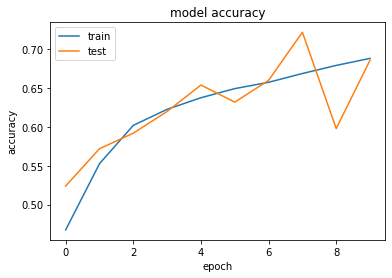

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 2-1. Model test

In [18]:
# encoder for test
encoder_model = Model(encoder_inputs, encoder_states)

# decoder for test
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb_test = dec_emb_layer(decoder_inputs)

decoder_outputs_test, state_h_test, state_c_test = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)
decoder_states_test = [state_h_test, state_c_test]

decoder_outputs_test = decoder_dense(decoder_outputs_test)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs_test] + decoder_states_test)

In [19]:
src_to_index = tokenizer_src.word_index
index_to_src = tokenizer_src.index_word 

tar_to_index = tokenizer_tar.word_index
index_to_tar = tokenizer_tar.index_word 

In [20]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    # _에 해당하는 정수 생성
    tar_seq = np.zeros((1,1))
    tar_seq[0, 0] = tar_to_index['_']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([tar_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sentence += sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '!' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        tar_seq = np.zeros((1,1))
        tar_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [21]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['_']) and i!=tar_to_index['!']):
            temp = temp + index_to_tar[i]
    return temp

# 임의의 텍스트 시퀀스를 정수 시퀀스로 변환
def txt2int(input_seq):
  temp = [[c for c in input_seq]]
  temp = tokenizer_src.texts_to_sequences(temp)
  return pad_sequences(temp, maxlen = 7, padding="post")

In [22]:
for _ in range(10):
  a = np.random.randint(0, 1000)
  b = np.random.randint(0, 1000)
  c = a+b
  input_seq = txt2int(f'{a}+{b}')
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",f'{a}+{b}')
  print("번역문 :",str(c))
  print("예측문 :",decoded_sentence[:-1])
  print('\n')

원문 :  710+843
번역문 : 1553
예측문 : 1555


원문 :  395+986
번역문 : 1381
예측문 : 1381


원문 :  960+939
번역문 : 1899
예측문 : 1877


원문 :  944+122
번역문 : 1066
예측문 : 1067


원문 :  241+533
번역문 : 774
예측문 : 777


원문 :  759+198
번역문 : 957
예측문 : 955


원문 :  489+394
번역문 : 883
예측문 : 888


원문 :  491+219
번역문 : 710
예측문 : 718


원문 :  137+393
번역문 : 530
예측문 : 528


원문 :  677+224
번역문 : 901
예측문 : 901




### 3. Modeling - Peeky

In [23]:
# encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) 
encoder_lstm = LSTM(latent_dim, return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 
encoder_states = [state_h, state_c] 

# decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) 
dec_emb = dec_emb_layer(decoder_inputs) 

# context vector를 각 time step에서의 입력과 합쳐줌
hs = RepeatVector(5)(state_h)
cs = RepeatVector(5)(state_c)
dec_emb = Concatenate(axis=-1)([dec_emb, hs, cs])

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, epochs = 10)

Epoch 1/10
1560/1560 [==============================] - 13s 7ms/step - loss: 1.5768 - acc: 0.4383 - val_loss: 1.2356 - val_acc: 0.5120
Epoch 2/10
1560/1560 [==============================] - 10s 6ms/step - loss: 1.1897 - acc: 0.5470 - val_loss: 1.0042 - val_acc: 0.6320
Epoch 3/10
1560/1560 [==============================] - 10s 6ms/step - loss: 0.9579 - acc: 0.6446 - val_loss: 0.6876 - val_acc: 0.7220
Epoch 4/10
1560/1560 [==============================] - 10s 6ms/step - loss: 0.6530 - acc: 0.7696 - val_loss: 0.4764 - val_acc: 0.8300
Epoch 5/10
1560/1560 [==============================] - 10s 6ms/step - loss: 0.4609 - acc: 0.8477 - val_loss: 0.3535 - val_acc: 0.8860
Epoch 6/10
1560/1560 [==============================] - 10s 6ms/step - loss: 0.3527 - acc: 0.8911 - val_loss: 0.3085 - val_acc: 0.8900
Epoch 7/10
1560/1560 [==============================] - 10s 6ms/step - loss: 0.2778 - acc: 0.9198 - val_loss: 0.2232 - val_acc: 0.9400
Epoch 8/10
1560/1560 [==============================] -

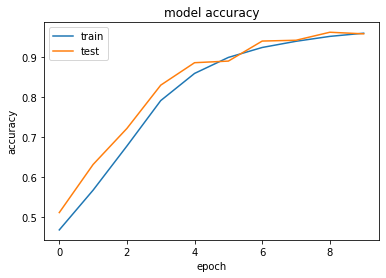

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 3-1. Peeky model test

In [26]:
# encoder for test
encoder_model = Model(encoder_inputs, encoder_states)

# decoder for test
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 처음 시점의 상태를 보관할 텐서
original_state_input_h = Input(shape=(latent_dim,))
original_state_input_c = Input(shape=(latent_dim,))
original_state_inputs = [original_state_input_h, original_state_input_c]

dec_emb_test= dec_emb_layer(decoder_inputs)
hs_test = RepeatVector(1)(original_state_inputs[0])
cs_test = RepeatVector(1)(original_state_inputs[1])
dec_emb_test = Concatenate(axis=-1)([dec_emb_test, hs_test, cs_test])

decoder_outputs_test, state_h_test, state_c_test = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)
decoder_states_test = [state_h_test, state_c_test]

decoder_outputs_test = decoder_dense(decoder_outputs_test)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs + original_state_inputs,
    [decoder_outputs_test] + decoder_states_test)

In [27]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    original_h, original_c = encoder_model.predict(input_seq)
    original_state = [original_h, original_c]
    states_value = [original_h, original_c]
    
    # _에 해당하는 정수 생성
    tar_seq = np.zeros((1,1))
    tar_seq[0, 0] = tar_to_index['_']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        # orginal_state는 encoder에서 나온 context vector로 계속 유지
        output_tokens, h, c = decoder_model.predict([tar_seq] + states_value + original_state)

        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sentence += sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '!' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        tar_seq = np.zeros((1,1))
        tar_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [28]:
for _ in range(10):
  a = np.random.randint(0, 1000)
  b = np.random.randint(0, 1000)
  c = a+b
  input_seq = txt2int(f'{a}+{b}')
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",f'{a}+{b}')
  print("번역문 :",str(c))
  print("예측문 :",decoded_sentence[:-1])
  print('\n')

원문 :  951+991
번역문 : 1942
예측문 : 1942


원문 :  257+679
번역문 : 936
예측문 : 936


원문 :  533+220
번역문 : 753
예측문 : 753


원문 :  734+332
번역문 : 1066
예측문 : 1066


원문 :  111+442
번역문 : 553
예측문 : 553


원문 :  245+717
번역문 : 962
예측문 : 962


원문 :  466+399
번역문 : 865
예측문 : 865


원문 :  427+248
번역문 : 675
예측문 : 675


원문 :  465+522
번역문 : 987
예측문 : 987


원문 :  869+613
번역문 : 1482
예측문 : 1482


